# Mean Reversion -  (Pairs Trading)
- Long Pair: Long stock A and short stock B
- Short Pair: Short stock A and long stock B
- You want to find a high correlation between stock A and B's price (usually > 0.8) --  in this case let's say 0.9. If you find a relationship suggesting that the prices move in opposite directions, you can capitalize on this behavior. ONCE the assets deviate from their typical correlation, say 0.5, you can long/short the pair since you expect the correlation to converge back to its original form.
- Sort of becomes an art when you try to maximize the spread between the assets

# Basic Idea
- 1) Find 2 assets that move similarly with eachother (whether it be a negative or positive correlation)
- 2) Sell the 'overvalued' stock and buy the 'undervalued' stock
-- A common signal to use to triger the purchase of a pair trade is to use the Price Ratio (Stock A / Stock B). If the ratio changes significantly, then you know it is time to trade. 'Significance' can be measured with standard deviation.

In [1]:
# The market is open 252 times in a given year.
# I will get the adjusted close as my main data.

import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf

def get_historical_Data(tickers):
    """This function returns a pd dataframe with all of the adjusted closing information"""
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        data = pd.concat([data, pd.DataFrame(yf.download(i, start=datetime(2014, 1, 1), end=datetime(2014, 12, 31)).iloc[:,4])], axis = 1)
        names.append(i)
    data.columns = names
    return data

ticks = ["PEP", "KO"] #Name of company (Dominos pizza)
d = get_historical_Data(ticks)
print(d.shape)
# Most Recent Data
d.tail()

PEP = d.PEP
KO = d.KO

/var/folders/dx/43ncnm1d5qv9l3zlwnb004wh0000gn/T/ipykernel_93211/1142394937.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/Ahmad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

(251, 2)


In [2]:
d.head(100)

,PEP,KO
Date,,
2014-01-02,61.113209,29.601599
2014-01-03,61.217415,29.455984
2014-01-06,61.247185,29.317661
2014-01-07,62.140465,29.405024
2014-01-08,61.961823,29.077410
...,...,...
2014-05-20,64.206825,29.777426
2014-05-21,64.544174,29.990225
2014-05-22,64.154350,29.777426


In [3]:
corr_matrix = d.corr()
corr_matrix

,PEP,KO
PEP,1.000000,0.910638
KO,0.910638,1.000000


<Axes: >

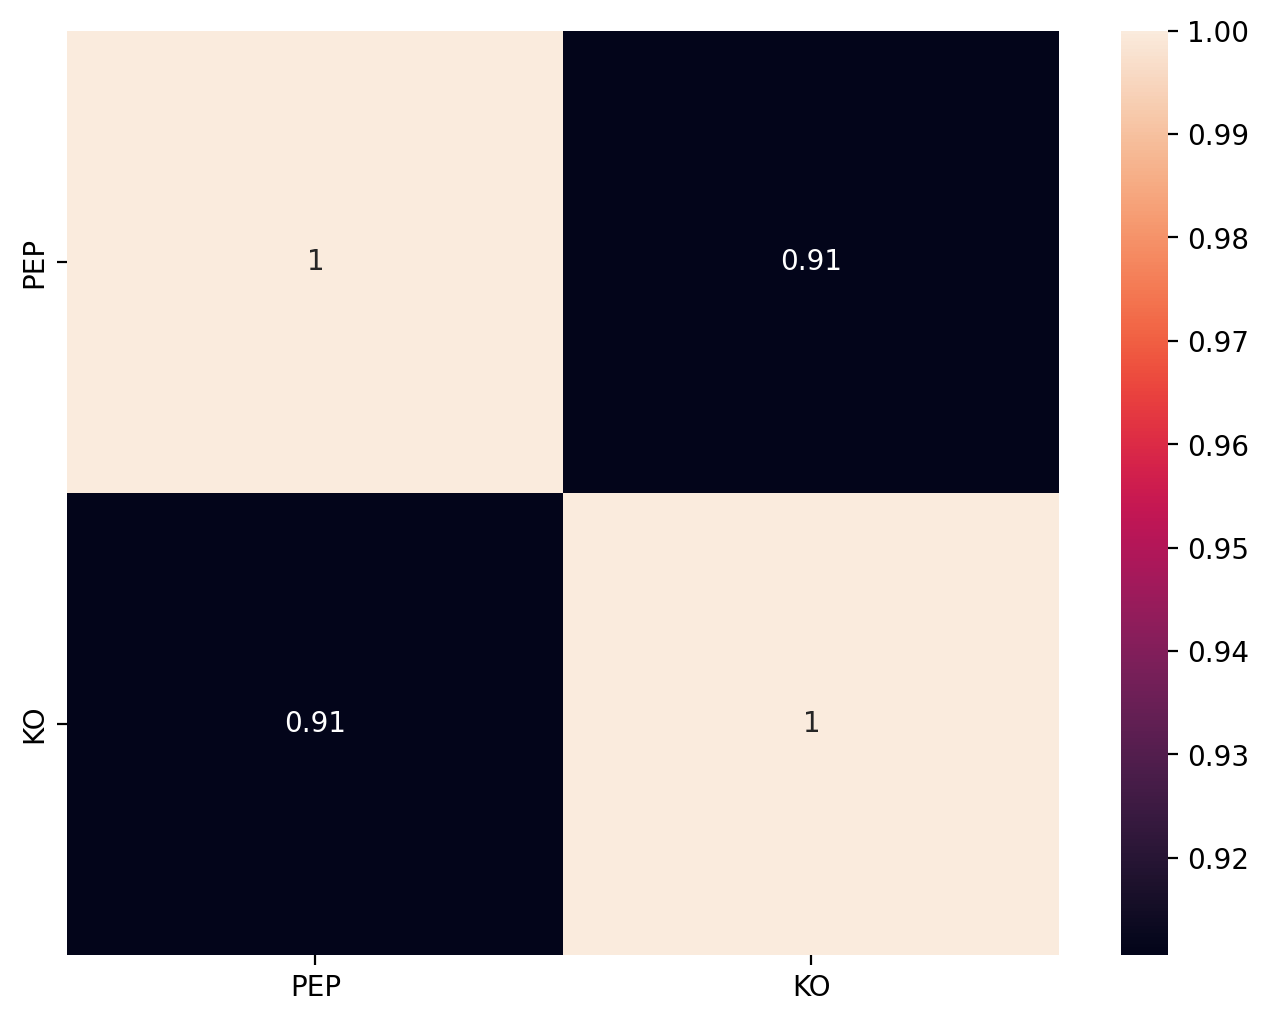

In [4]:
# Let's heatmap this matrix so that we can have a better sense of what is going on
import seaborn as sn
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=200)
sn.heatmap(corr_matrix, annot = True)

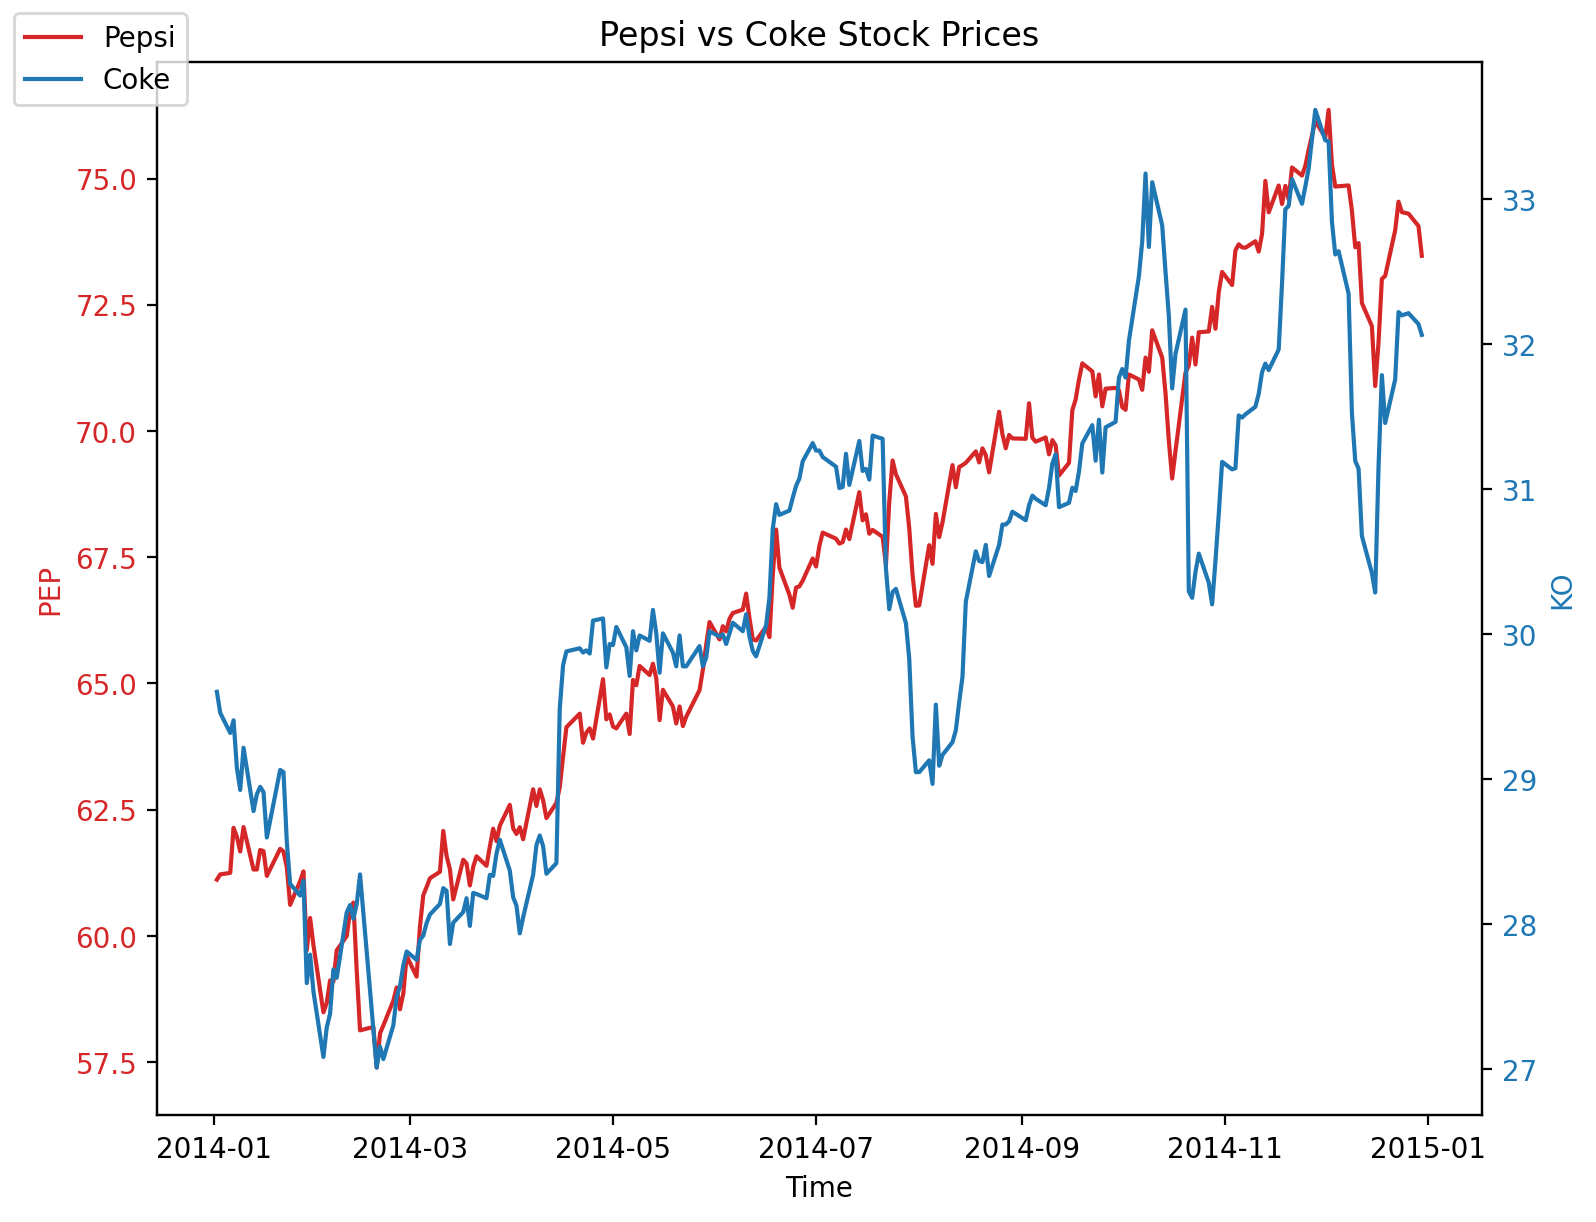

In [5]:
import matplotlib.pyplot as plt

# Assuming d['PEP'] and d['KO'] are your time series data for Pepsi and Coke respectively

fig, ax1 = plt.subplots(figsize=(8, 6), dpi=200)

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('PEP', color=color)
ax1.plot(PEP, color=color, label='Pepsi')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('KO', color=color)  # we already handled the x-label with ax1
ax2.plot(KO, color=color, label='Coke')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Pepsi vs Coke Stock Prices')
fig.legend(loc="upper left")
plt.show()


Text(0.5, 1.0, 'Spread between PEP and KO')

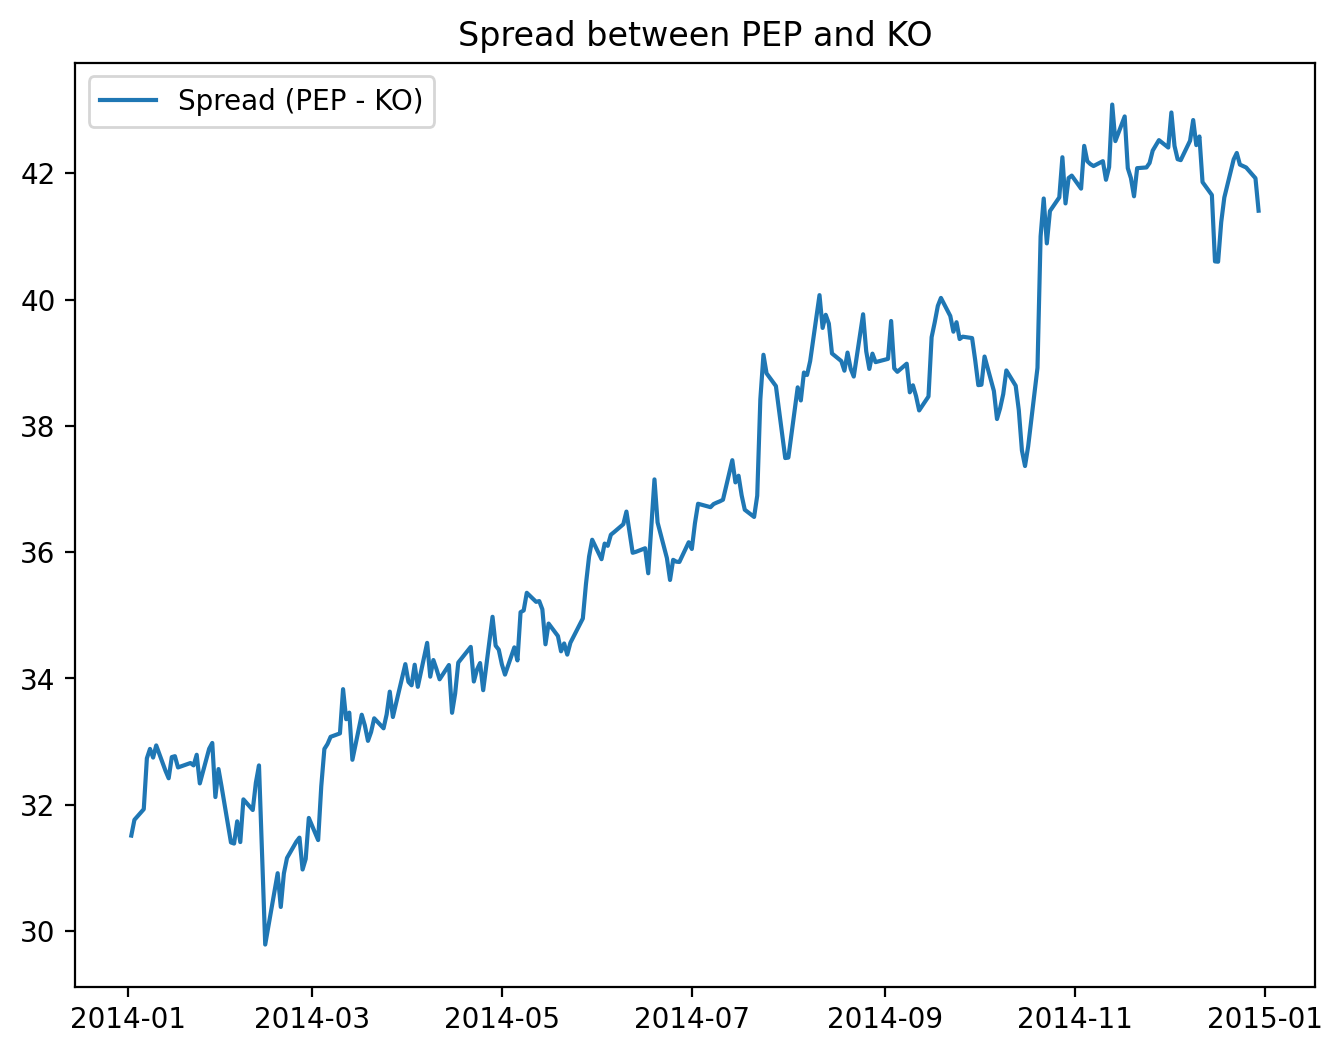

In [6]:
# plot the spread
figure(figsize=(8, 6), dpi=200)
plt.plot(PEP - KO, label = 'Spread (PEP - KO)')
plt.legend()
plt.title("Spread between PEP and KO")


In [7]:
# Check out the cointegration value: Null hyp. = no cointegration
import statsmodels.tsa.stattools as ts
result = ts.coint(PEP, KO)
result

(-3.442558441812627,
 0.037838608907726785,
 array([-3.94078403, -3.36067957, -3.06145832]))

In [8]:
# Cointegration test: A technique used to find a potential correlation in a time series (long term)
# Determines if the spread between the two assets are constant over time.
# Null Hypothesis: Spread between series are non-stationary.
# Uses the augmented Engle-Granger two-step cointegration test.
cointegration_t_statistic = result[0]
p_val = result[1]
critical_values_test_statistic_at_1_5_10 = result[2]
print('We want the P val < 0.05 (meaning that cointegration exists)')
print('P value for the augmented Engle-Granger two-step cointegration test is', p_val)

We want the P val < 0.05 (meaning that cointegration exists)
P value for the augmented Engle-Granger two-step cointegration test is 0.037838608907726785


In [9]:
from statsmodels.tsa.stattools import adfuller
# Compute the ADF test for KO and PEP
# With all time series, you want to have stationary data otherwise our data will be very hard to predict.
PEP_ADF = adfuller(PEP)
print('P value for the Augmented Dickey-Fuller Test is', PEP_ADF[1])
KO_ADF = adfuller(KO)
print('P value for the Augmented Dickey-Fuller Test is', KO_ADF[1])
Spread_ADF = adfuller(PEP - KO)
print('P value for the Augmented Dickey-Fuller Test is', Spread_ADF[1])
Ratio_ADF = adfuller(PEP / KO)
print('P value for the Augmented Dickey-Fuller Test is', Ratio_ADF[1])
# Spread looks fine. If you'd want even better results, consider taking the difference (order 1) of KO and PEP

# Results: can only claim stationary for the spread (since P value < 0.05). This suggests a constant mean over time.
# Therefore, the two series are cointegrated.

P value for the Augmented Dickey-Fuller Test is 0.9146175699607307
P value for the Augmented Dickey-Fuller Test is 0.6653549517631361
P value for the Augmented Dickey-Fuller Test is 0.8578035388460746
P value for the Augmented Dickey-Fuller Test is 0.11197932731445981


In [10]:
ratio = d.PEP / d.KO

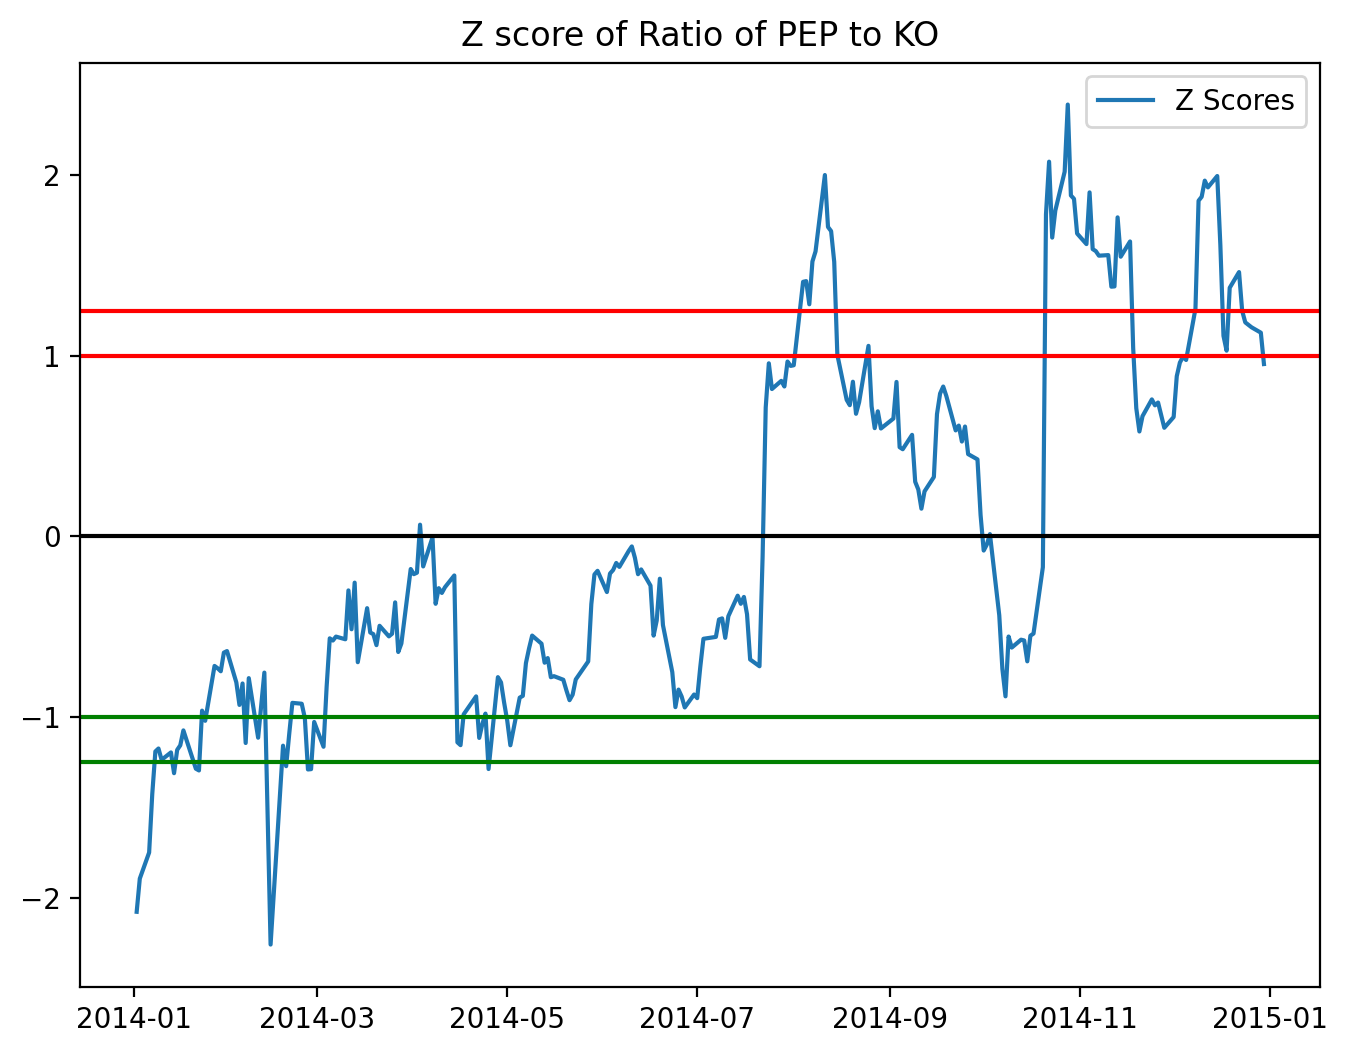

In [11]:
# NOTE, here you can either use the spread OR the Price ratio approach. Anyways, let's standardize the ratio so we can have a
# upper and lower bound to help evaluate our trends.. Let's stick with the ratio data.
figure(figsize=(8, 6), dpi=200)
# Calculate the Zscores of each row.
df_zscore = (ratio - ratio.mean())/ratio.std()
plt.plot(df_zscore, label = "Z Scores")
plt.axhline(df_zscore.mean(), color = 'black')
plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(1.25, color='red') # 95% of our data will lie between these bounds.
plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
plt.axhline(-1.25, color='green') # 95% of our data will lie between these bounds.
plt.legend(loc = 'best')
plt.title('Z score of Ratio of PEP to KO')
plt.show()
# For the most part, the range that exists outside of these 'bands' must come converge back to the mean. Thus, you can
# determine when you can go long or short the pair (PEP to KO).

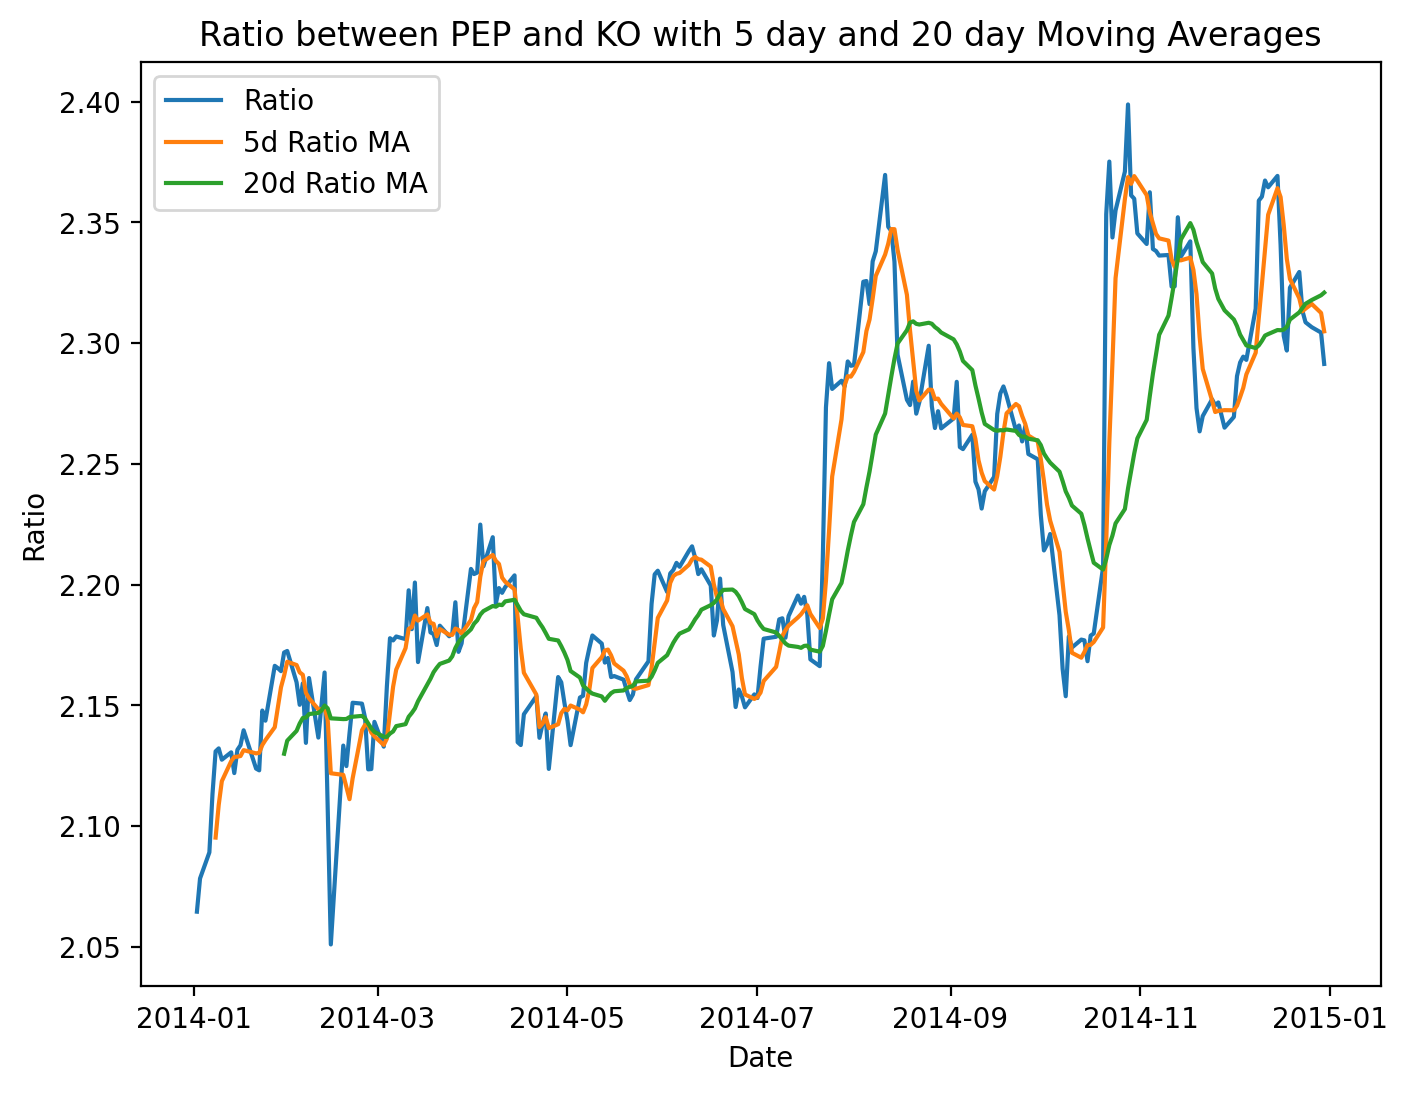

In [12]:
figure(figsize=(8, 6), dpi=200)
ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
ratios_mavg20 = ratio.rolling(window=20, center=False).mean()
std_20 = ratio.rolling(window=20, center=False).std()
zscore_20_5 = (ratios_mavg5 - ratios_mavg20)/std_20
plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg20.index, ratios_mavg20.values)
plt.legend(['Ratio', '5d Ratio MA', '20d Ratio MA'])
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Ratio between PEP and KO with 5 day and 20 day Moving Averages')
plt.show()

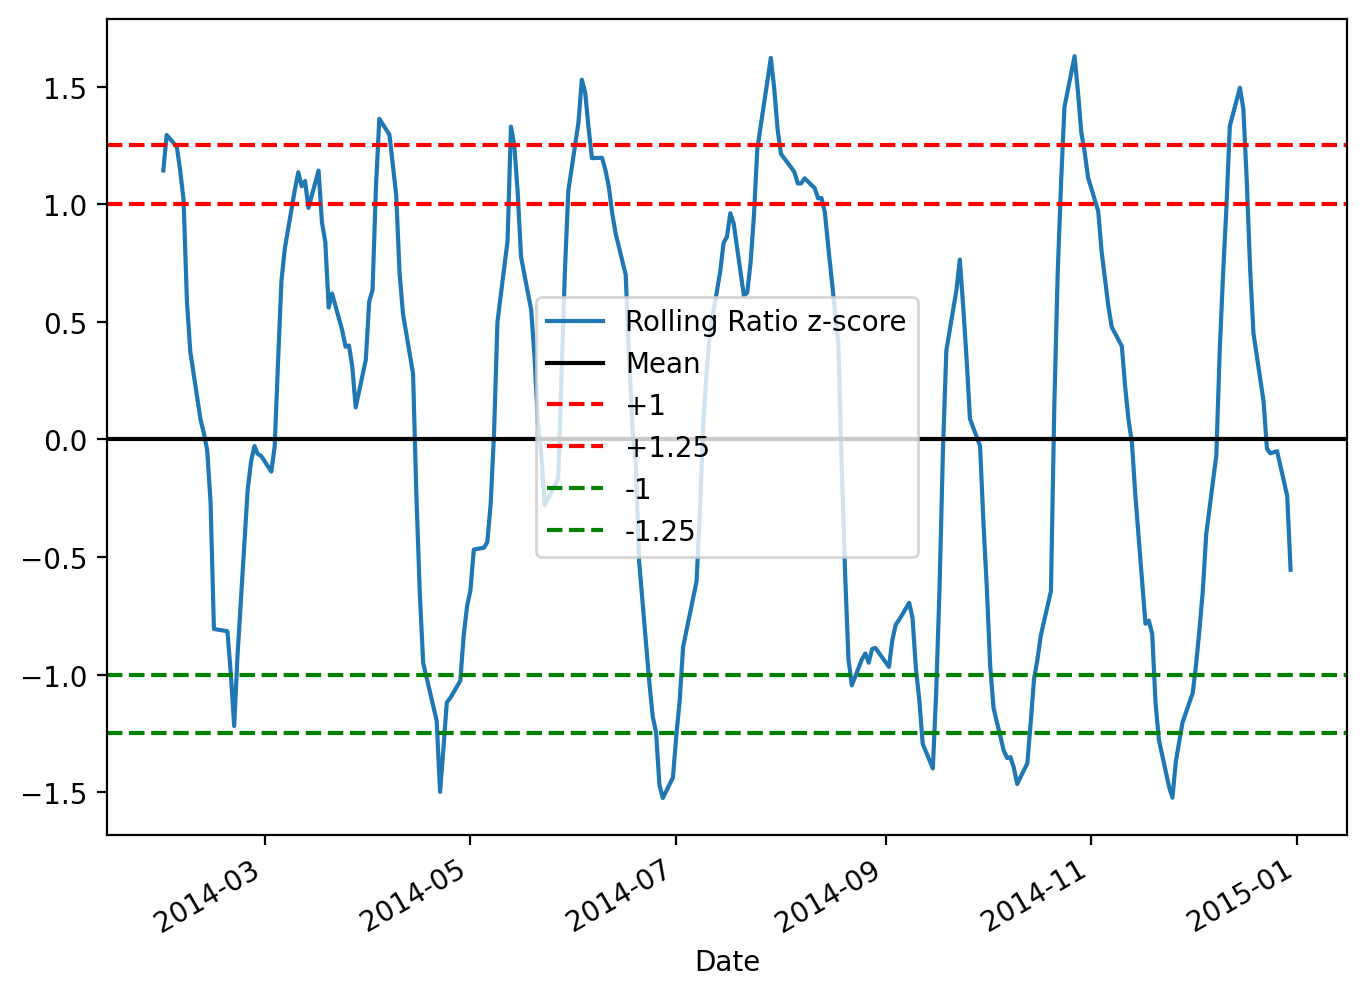

In [13]:
figure(figsize=(8, 6), dpi=200)
zscore_20_5.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(1.25, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(-1.25, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'])
plt.show()

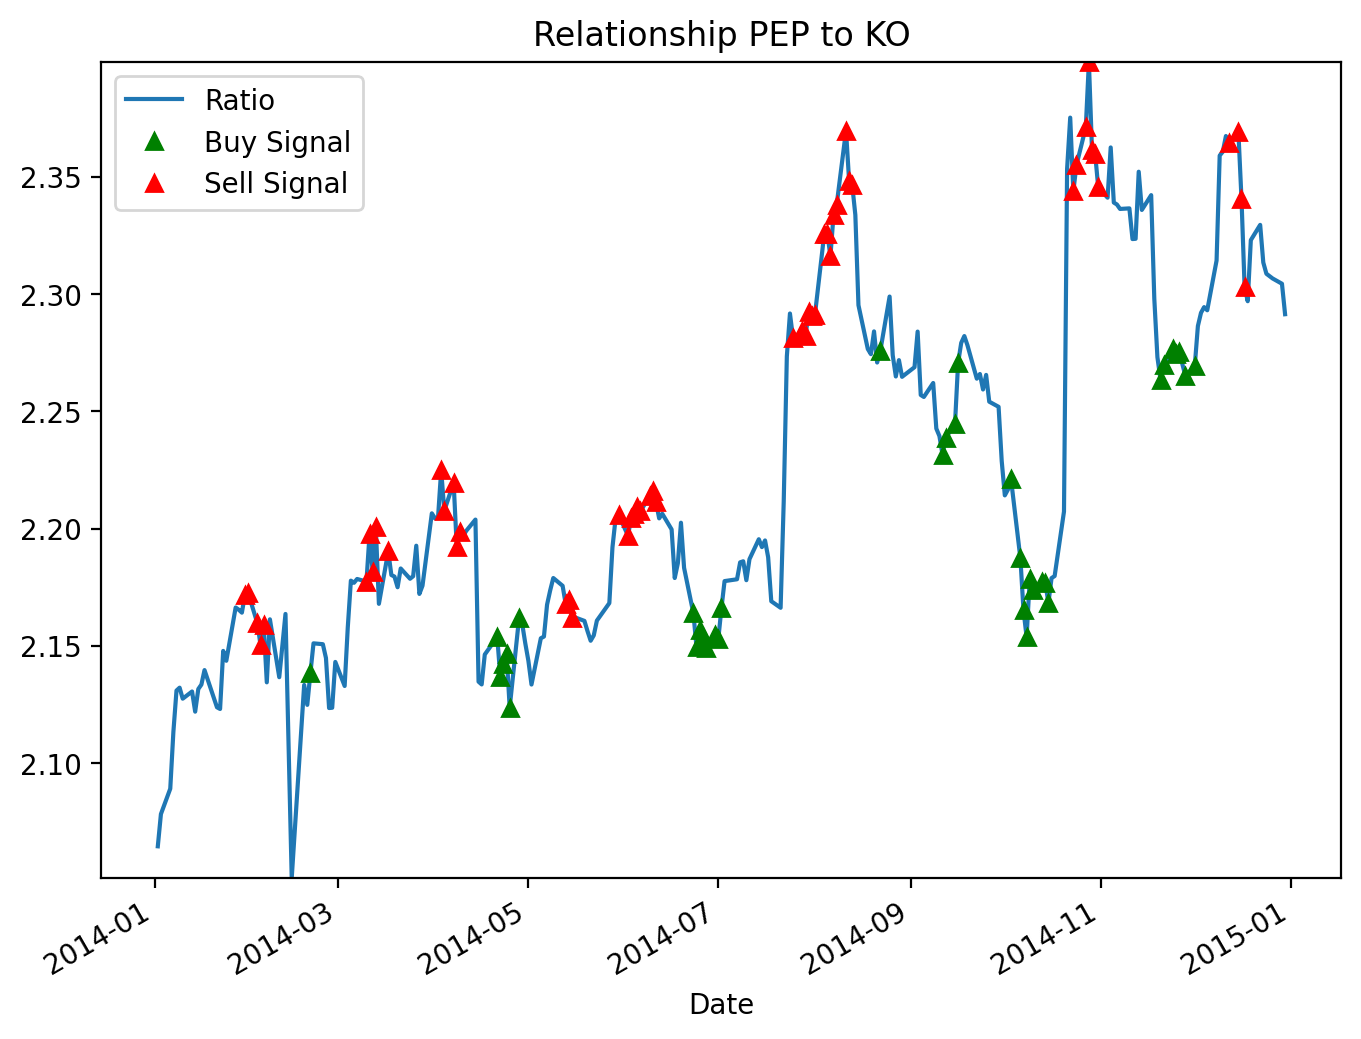

In [117]:
figure(figsize=(8, 6), dpi=200)
ratio.plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_20_5>-1] = 0
sell[zscore_20_5<1] = 0
buy[zscore_20_5.isna()] = 0
sell[zscore_20_5.isna()] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship PEP to KO')
plt.show()

## Search for profitability

The cell below will deal with pre-processing the sentiment analysis data of the year 2014 in order to use them to scale trades up an down based on sentiment in the later section.

In [ ]:
import ast
import math

########### Calculating the trade scale for pepsi ##################

# import the pepsi sentiment analysis data
pepsi_sentiment_df = pd.read_csv('pepsi tweets data.csv')

# convert the string literal representations of the sentiment lists
# from the csv file into an actual list data structure
pepsi_sentiment_df['sentiment'] = pepsi_sentiment_df['sentiment'].apply(ast.literal_eval)

# reverse the order of the sentiment analysis rating list if the content is detected to be sarcastic
pepsi_sentiment_df['sentiment'] = pepsi_sentiment_df.apply(lambda row: row['sentiment'][::-1] if row['sarcasm'] > 0.85 else row['sentiment'], axis=1)

# we're going to be adding a new column into the pepsi_sentiment_df, the content of the column will be
# present inputted into the trade_scale list
trade_scale = []

# loop that converts every sentiment rating into a percentage representation and multiplies it by 2
# making the trade_scale column a float type with values ranging from 0 to 2
for i in range(len(pepsi_sentiment_df)):
    trade_scale.append(sum([count*x/2 for count,x in enumerate(pepsi_sentiment_df['sentiment'][i])]))

# create a new column called 'trade scale' and input the trade_scale list as the data
pepsi_sentiment_df['trade scale'] = trade_scale

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

########### Calculating the trade scale for coke ##################

# import the coke sentiment analysis data
coke_sentiment_df = pd.read_csv('coke tweets data.csv')

# convert the string literal representations of the sentiment lists
# from the csv file into an actual list data structure
coke_sentiment_df['sentiment'] = coke_sentiment_df['sentiment'].apply(ast.literal_eval)

# reverse the order of the sentiment analysis rating list if the content is detected to be sarcastic
coke_sentiment_df['sentiment'] = coke_sentiment_df.apply(lambda row: row['sentiment'][::-1] if row['sarcasm'] > 0.85 else row['sentiment'], axis=1)

# we're going to be adding a new column into the coke_sentiment_df, the content of the column will be
# present inputted into the trade_scale list
trade_scale = []

# loop that converts every sentiment rating into a percentage representation and multiplies it by 2
# making the trade_scale column a float type with values ranging from 0 to 2
for i in range(len(coke_sentiment_df)):
    trade_scale.append(sum([count*x/2 for count,x in enumerate(coke_sentiment_df['sentiment'][i])]))

# create a new column called 'trade scale' and input the trade_scale list as the data
coke_sentiment_df['trade scale'] = trade_scale




The cell below implements the actual trade based on the cointegration strategy outlined earlier

Sharpe Ratio: 26.679447893960802


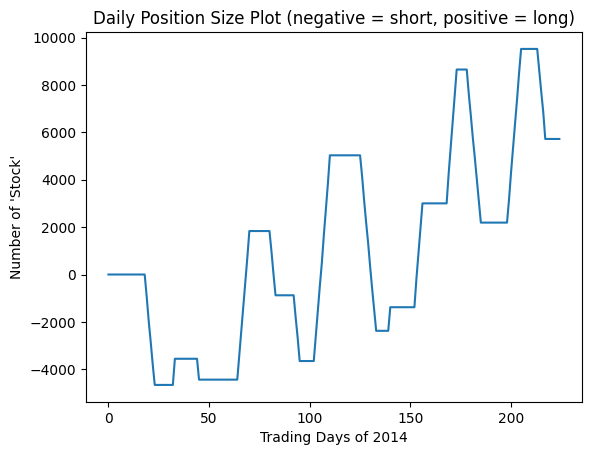

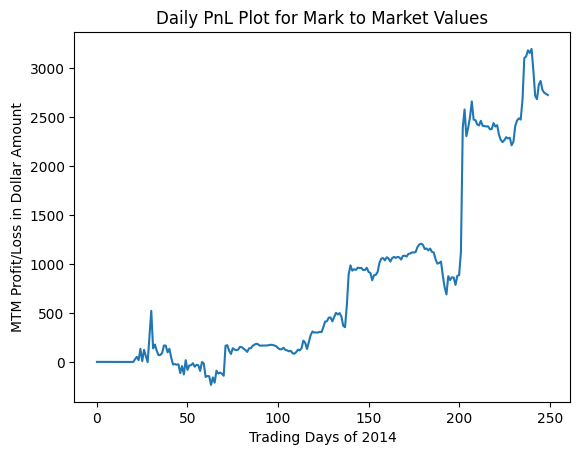

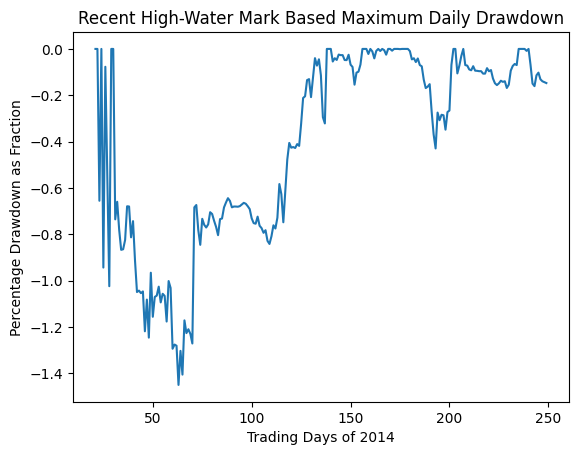

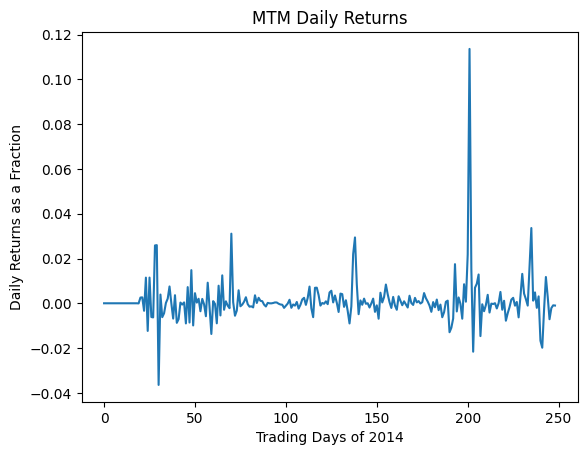

In [186]:
import numpy as np
import functools
import operator

test_data = d
test_ratio = ratio
test_buy = buy
test_sell = sell

capital = 10000  # Initial capital
position_size = 1000  # Number of shares to trade per position
max_trades = 5  # Maximum number of trades allowed per week

pnl = 0  # Initialize P&L
pnl_list = [] # tracks daily pnl values
positions = []  # Track positions taken
position = 0  # Initialize trades counter for the current week
current_week = None  # Track the current week
holding_position = 0 # Tracks holding position sizes
trade_multiplier = 1 # the trade multiplier scaling based on the sentiment
returns = [] # contains daily returns
holding_position_list = [] # tracks daily holding position sizes

for i in range(len(test_data) - 1):  # Loop until the second last index
    entry_ratio = test_ratio.iloc[i]

    # calculate the sentiment based trade multiplier based on the difference in sentiment between pepsi and coke
    test_data_date = str(test_data.index[i])[5:10]
    day_df_pep = pepsi_sentiment_df[pepsi_sentiment_df['date'] == test_data_date]
    day_df_ko = coke_sentiment_df[coke_sentiment_df['date'] == test_data_date]
    trade_multiplier = (day_df_pep['trade scale'].mean() - day_df_ko['trade scale'].mean())/2 + 1

    # deals with undefined trade multiplier values
    if math.isnan(trade_multiplier):
        trade_multiplier = 1
    
    # calculate the MTM daily position value minus the initial capital
    pnl = capital + (holding_position * entry_ratio) - 10000
    # saves that day's pnl into a list
    pnl_list.append(capital + (holding_position * entry_ratio) - 10000)

    # save today's return into a list, starting with the second day
    if i>0:
        returns.append((pnl_list[-1]-pnl_list[-2])/(pnl_list[-2]+10000))

    # if buy signal is on, execute a buy
    if test_buy.iloc[i]:

        #cap the max buy position at 5 positions
        if position == 5:
            # No action taken on this day if it's already at 5
            positions.append(('NO ACTION', entry_ratio))
            continue

        # increment the position variable because a buy is about to happen
        position += 1

        # calculate the latest holding position in number of stocks
        holding_position += position_size * trade_multiplier

        # decrement the cash capital amount by the price x amount bought
        capital -= position_size * entry_ratio * trade_multiplier

        # track that a buy happened at a today's market price
        positions.append(('BUY', entry_ratio))
    
    # if a sell signal is on, execute a sell
    elif test_sell.iloc[i]:

        # cap the max sell position at -5 positions
        if position == -5:
                # No action taken on this day if it's already at -5
            positions.append(('NO ACTION', entry_ratio))
            continue

        # decrement the position variable because sell is about to happen
        position -= 1

        # calculate the latest holding position in number of stocks based on recent sell
        holding_position -= position_size / trade_multiplier

        # increment the cash capital amount by price x amount sold
        capital += position_size * entry_ratio / trade_multiplier

        # track that a sell happened at today's market price
        positions.append(('SELL', entry_ratio))
    
    # if no buy or sell signal dont do anything that day
    else:
        positions.append(('NO ACTION', entry_ratio))

    # save today's holding position into a list to track and plot later
    holding_position_list.append(holding_position)


# Calculate Sharpe Ratio
total_return = functools.reduce(operator.mul, [x+1 for x in returns]) -1
std_dev = np.std(returns)  # Compute the standard deviation of cumulative P&L
sharpe_ratio = total_return / std_dev if std_dev != 0 else 0  # Avoid division by zero

# Calculate drawdown
window = 250
Roll_Max = pd.DataFrame(pnl_list).rolling(window, min_periods=1).max()
Daily_Drawdown = pd.DataFrame(pnl_list)/Roll_Max - 1.0

# Print total P&L, Sharpe Ratio, drawdown, and cumulative positives
print("Sharpe Ratio:", sharpe_ratio)

############# Plot relevant data #####################

# plot daily position size where negative number means we're shorting and positive means we're holding
plt.plot(holding_position_list)
plt.title("Daily Position Size Plot (negative = short, positive = long)")
plt.xlabel("Trading Days of 2014")
plt.ylabel("Number of 'Stock'")
plt.show()

# plot daily PnL where positive is profit and negative is loss
plt.plot(pnl_list)
plt.title("Daily PnL Plot for Mark to Market Values")
plt.xlabel("Trading Days of 2014")
plt.ylabel("MTM Profit/Loss in Dollar Amount")
plt.show()

# plot daily max drawdown in percentage
plt.plot(Daily_Drawdown)
plt.title("Recent High-Water Mark Based Maximum Daily Drawdown")
plt.xlabel("Trading Days of 2014")
plt.ylabel("Percentage Drawdown as Fraction")
plt.show()

# plot daily max drawdown in percentage
plt.plot(returns)
plt.title("MTM Daily Returns")
plt.xlabel("Trading Days of 2014")
plt.ylabel("Daily Returns as a Fraction")
plt.show()